## Noisy RGB pixels, UNet + Attention + Conv + Residual, 1/8 U-Net bottleneck, L1/L2 + Perceptual + Adversarial Loss + Color Correction 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
from plot_data import load_data

import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def load_data_file(filename, verbose=False):
    bufferview = load_data(filename)
    images = {}
    img_sum = 0.0 * bufferview[0]['buffer']
    w = 0.0
    for image in bufferview:
        images[image['name']] = image['buffer']
        if not image['name'] >= 1:
            continue
        w += image['name']
        img_sum += image['name'] * image['buffer']

    # noise images less than 1spp
    sub = []
    for e in range(1, 4+1, 1):
        spp = 2**(-e)
        if spp not in images:
            break
        img = np.nan_to_num(images[spp], nan=0.0, posinf=0.0, neginf=0.0)
        sub.append(img)

    # power of 2 images greater than 1spp
    data = []
    for e in range(0, len(images)-len(sub)):
        spp = 2**e
        if spp not in images:
            break
        data.append(images[spp])
    data = np.array(data)
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    # reference image, denoise with oidn
    ref = img_sum / w
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2

    if verbose:
        print(len(sub), data.shape, data.dtype, ref.shape, ref.dtype)
        plot_frame(ref**(1.0/2.2))
    return {
        'sub': sub,
        'data': data,
        'ref': ref
    }

# _ = load_data_file("data/implicit3-rt_0c2c00f9b182_1024.bin", verbose=True)

torch.Size([8, 3, 256, 256])


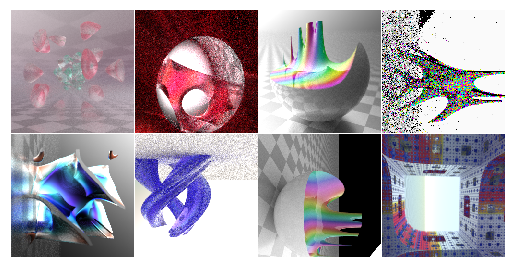

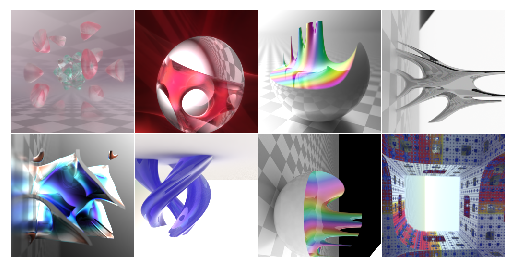

In [3]:
import random

class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = []
        for root, dirs, files in os.walk('data/'):
            for filename in files:
                filename = os.path.join(root, filename)
                try:
                    self.data.append(load_data_file(filename))
                except:
                    pass
        self.n = n
    
    def __len__(self):
        return self.n

    def __getitem__(self, i):

        # random data
        img = self.data[random.randint(0,len(self.data)-1)]
        clean = img['ref']

        # random chance to get <1spp image
        if random.random() < 0.0:
            noisy = random.choice(img['sub'])

        # clean image - random spp, sample from spp
        else:
            n = img['data'].shape[0]
            spp = max(round(0.6 * np.random.random()**4 * 2**n), 1)
            total = 0.0
            weight = 0.0
            for _ in range(n):
                if (spp >> _) & 1 == 0:
                    continue
                frame = img['data'][_]
                dw = ((frame > 0.0) & (frame < 1e6)).astype(np.float32) * 2**_
                total += frame * dw
                weight += dw
            noisy = total / np.fmax(weight, 1.0)

        # random flip/rotate/transpose
        if random.random() < 0.5:
            noisy = np.flip(noisy, 0)
            clean  = np.flip(clean,  0)
        if random.random() < 0.5:
            noisy = np.flip(noisy, 1)
            clean = np.flip(clean, 1)
        if random.random() < 0.5:
            noisy = np.swapaxes(noisy,  1, 2)
            clean = np.swapaxes(clean, 1, 2)

        # random swap color channels
        cidx = [0, 1, 2]
        random.shuffle(cidx)
        noisy = noisy[cidx]
        clean = clean[cidx]

        return [
            np.fmax(noisy, 0.0) ** (1.0/2.2),
            np.fmax(clean, 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:8].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [4]:
# inspired by https://peerj.com/articles/cs-970/


class AttentionChannelOnly(nn.Module):
    def __init__(self, C):
        super(AttentionChannelOnly, self).__init__()

        self.C = C
        self.conv1 = nn.Conv2d(C,1, 1,1,0)
        self.conv2 = nn.Conv2d(C,C//2, 1,1,0)
        self.conv3 = nn.Linear(C//2,C)

    def forward(self, x):
        x1 = self.conv1(x)  # (1,H,W)
        x1 = F.softmax(x1.view(x.shape[0], -1), dim=1).view_as(x1)
        
        x2 = self.conv2(x)  # (C/2,H,W)
        
        x3 = torch.sum(x1*x2, (2,3))  # (C/2,)
        x3 = self.conv3(x3)  # (C,)
        x3 = torch.sigmoid(x3)  # (C,)
        
        return torch.mul(x, x3[:,:,None,None])  # (C,H,W)


class AttentionSpacialOnly(nn.Module):
    def __init__(self, C):
        super(AttentionSpacialOnly, self).__init__()

        self.C = C
        self.conv1 = nn.Conv2d(C,C//2, 1, padding=0)
        self.conv2 = nn.Conv2d(C,C//2, 1, padding=0)
        
    def forward(self, x):
        x1 = self.conv1(x)  # (C/2,H,W)
        x1 = torch.mean(x1, (2, 3))  # (C/2,)
        x1 = torch.softmax(x1, dim=1)  # (C/2,)

        x2 = self.conv2(x)  # (C/2,H,W)

        # x3 = torch.einsum('ki,kihw->khw', x1, x2)
        x3 = torch.sum(x1[:,:,None,None]*x2, (1,))  # (H,W)
        x3 = torch.sigmoid(x3)  # (H,W)

        return torch.mul(x, x3[:,None,:,:])


class Model(nn.Module):
    def __init__(self, K1, K2, K3, K4, Ko):
        super(Model,self).__init__()
        
        def conv3s1(in_c,out_c):
            """3x3 conv, no dimension change"""
            return nn.Conv2d(in_c,out_c, 3,1,1)

        def conv3s2(in_c,out_c):
            """3x3 conv, reduce dimension by half"""
            return nn.Conv2d(in_c,out_c, 3,2,1)

        def dconv4s2(in_c,out_c):
            """twice the dimension"""
            return nn.ConvTranspose2d(in_c,out_c, 4,2,1)

        self.enc1 = conv3s1(3,K1)  # 1
        self.div1 = conv3s2(K1,K2)  # 1 -> 1/2

        self.enc2 = conv3s1(K2,K2)  # 1/2
        self.div2 = conv3s2(K2,K3)  # 1/2 -> 1/4

        self.enc3 = conv3s1(K3,K3)  # 1/4
        self.div3 = conv3s2(K3,K4)  # 1/4 -> 1/8

        self.dec31 = conv3s1(K4,K4)  # 1/8
        self.dec32 = conv3s1(K4,K4)  # 1/8
        self.upc3 = dconv4s2(K4,K3)  # 1/8 -> 1/4

        self.dec21 = conv3s1(K3,K3)  # 1/4
        self.dec22 = conv3s1(K3,K3)  # 1/4
        self.upc2 = dconv4s2(K3+K3,K2)  # 1/4 -> 1/2

        self.dec11 = conv3s1(K2,K2)  # 1/2
        self.dec12 = conv3s1(K2,K2)  # 1/2
        self.upc1 = dconv4s2(K2+K2,Ko)  # 1/2 -> 1

        self.dec01 = conv3s1(Ko,Ko)  # 1
        self.dec02 = conv3s1(Ko,Ko)  # 1

        self.attention1 = AttentionChannelOnly(K1+Ko)
        self.attention2 = AttentionSpacialOnly(K1+Ko)
        self.convo = conv3s1(K1+Ko, 3)

    def forward(self,x):

        def concat(a,b):
            return torch.concat((a,b), axis=1)

        def relu(x, inplace=True):
            return F.relu(x, inplace)

        enc1 = self.enc1(x)  # 1
        div1 = self.div1(relu(enc1, False))  # 1/2
        enc2 = self.enc2(relu(div1))  # 1/2
        div2 = self.div2(relu(enc2, False))  # 1/4
        enc3 = self.enc3(relu(div2))  # 1/4
        div3 = self.div3(relu(enc3, False))  # 1/8
        dec3 = self.dec32(relu(self.dec31(relu(div3))))  # 1/8
        upc3 = self.upc3(relu(dec3))  # 1/4
        dec2 = self.dec22(relu(self.dec21(relu(upc3))))  # 1/4
        upc2 = self.upc2(concat(enc3,relu(dec2)))  # 1/2
        dec1 = self.dec12(relu(self.dec11(relu(upc2))))  # 1/2
        upc1 = self.upc1(concat(enc2,relu(dec1)))  # 1
        dec0 = self.dec02(relu(self.dec01(relu(upc1))))  # 1

        attention1 = self.attention1(concat(enc1,relu(dec0)))
        attention2 = self.attention2(attention1)
        convo = self.convo(attention2)
        return x + convo

model = Model(12, 16, 24, 32, 12).to(device)  # keep these multiples of 4
print(model)
x = torch.randn(1,3,256,256, device=device)
with torch.no_grad():
    y = model.forward(x)
print(y.shape)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total', num_params, 'parameters')


Model(
  (enc1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (div1): Conv2d(12, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (div2): Conv2d(16, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (div3): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (dec31): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec32): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upc3): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec21): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec22): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upc2): ConvTranspose2d(48, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec11): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1),

In [5]:
"""Image Denoising Using A Generative Adversarial Network,
    Code modified from implementation by Jeffrey Ming Han Li"""

class Discriminator(torch.nn.Module):
    def __init__(self,K2):
        super(Discriminator, self).__init__()

        # Basic convolutional block
        def conv_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.LeakyReLU(0.01, inplace=True)
            )
        def last_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels,out_channels,kernel_size,stride,1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Sigmoid()
            )

        self.model = torch.nn.Sequential(
            conv_block(3,K2, kernel_size=4, stride=2),
            conv_block(K2,3*K2//2, kernel_size=4, stride=2),
            conv_block(3*K2//2,K2*2, kernel_size=4, stride=2),
            conv_block(K2*2,K2*3, kernel_size=4, stride=2),
            conv_block(K2*3,K2*4, kernel_size=4, stride=2),
            conv_block(K2*4,K2*4, kernel_size=3, stride=1),
            last_block(K2*4,1, kernel_size=3, stride=1)
        )

    def forward(self, x):
        y = self.model(x)
        # print(y.shape)
        return torch.clip(torch.mean(y, axis=(2, 3)), 0.0, 1.0)


class CombinedLoss(torch.nn.Module):
    def __init__(self, lambda_a, lambda_p, lambda_f, lambda_c, device='cpu'):
        super(CombinedLoss, self).__init__()
        self.lambda_a = lambda_a  # adversarial
        self.lambda_p = lambda_p  # pixel loss
        self.lambda_f = lambda_f  # feature loss (perceptual)
        # self.lambda_t = lambda_t  # texture matching loss
        self.lambda_t = 0.0
        self.lambda_c = lambda_c  # correct color shift caused by GAN

        # loss function for GAN
        self.bce = torch.nn.BCEWithLogitsLoss()

        # VGG16 model for feature and texture loss
        import torchvision.models
        vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
        vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

        # vgg first layer
        self.feature_extractor = vgg16.features[:4].to(device)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.feature_extractor_1 = lambda x: self.feature_extractor((x-vgg_mean)/vgg_std)
        # print(self.feature_extractor)

        # vgg second layer, after first layer
        self.feature_extractor_2 = vgg16.features[4:9].to(device)
        for param in self.feature_extractor_2.parameters():
            param.requires_grad = False
        # print(self.feature_extractor_2)
    
    @staticmethod
    def gram(x, s):
        if x.shape[2] % s != 0 or x.shape[3] % s != 0:
            raise ValueError("Image dimension not multiple of texture patch size")
        x = x.view(x.shape[0], x.shape[1], x.shape[2]//s, s, x.shape[3]//s, s)
        x = x.permute(0, 1, 2, 4, 3, 5).contiguous()
        x = x.view(x.shape[0], x.shape[1], -1, s*s)
        g = torch.matmul(x, x.transpose(3, 2))
        return g / (s*s)
    
    @staticmethod
    def mask_non_finite(x, v):
        nan_mask = torch.isnan(x)
        inf_mask = torch.isinf(x)
        x[nan_mask] = v
        x[inf_mask] = v
        return x
    
    def forward(self, generated, target, discriminator_output, is_discriminator=False):
        # normalization parameters
        normalize_l2 = 1.0 / 0.05  # change this to estimated L1 loss
        normalize_vgg = 1.0 / 0.225
        normalize_l2_vgg = normalize_l2 / normalize_vgg
        normalize_l2_vgg_gram = normalize_l2_vgg ** 2

        # adversarial Loss
        if is_discriminator:
            return self.bce(discriminator_output, target)
        # loss_a = -torch.mean(discriminator_output)
        loss_a = self.bce(1.0-discriminator_output, torch.ones_like(discriminator_output))

        # pixel loss (L1+L2)
        loss_p2 = torch.mean((generated-target)**2) * normalize_l2
        loss_p1 = torch.mean(torch.abs(generated-target))
        loss_p = 0.5*(loss_p1+loss_p2)

        # feature loss (L1+L2)
        gen_features = self.feature_extractor_1(generated)
        tgt_features = self.feature_extractor_1(target)
        loss_f1l2 = torch.mean((gen_features-tgt_features)**2) * normalize_l2_vgg
        loss_f1l1 = torch.mean(torch.abs(gen_features-tgt_features))
        gen_features_2 = self.feature_extractor_2(gen_features)
        tgt_features_2 = self.feature_extractor_2(tgt_features)
        loss_f2l2 = torch.mean((gen_features_2-tgt_features_2)**2) * normalize_l2_vgg
        loss_f2l1 = torch.mean(torch.abs(gen_features_2-tgt_features_2))
        loss_f = 0.25*(loss_f1l2+loss_f1l1+loss_f2l2+loss_f2l1)

        # texture loss
        # loss_t1 = torch.mean(self.gram(gen_features,16)-self.gram(tgt_features,16))**2
        # # loss_t2 = torch.mean(self.gram(gen_features_2,8)-self.gram(tgt_features_2,8))**2
        # loss_t2 = torch.mean(self.gram(gen_features_2,16)-self.gram(tgt_features_2,16))**2
        # loss_t = (0.5*(loss_t1+loss_t2))**0.5 * normalize_l2_vgg_gram
        loss_t = 0.0

        # color correction loss
        generated_mapped = torch.nn.functional.avg_pool2d(
            torch.clip(torch.exp(generated)-1.0,0.0,1e3)**2.2, 32)
        target_mapped = torch.nn.functional.avg_pool2d(
            torch.clip(torch.exp(target)-1.0,0.0,1e3)**2.2, 32)
        generated_mapped = self.mask_non_finite(generated_mapped, 0.0)
        target_mapped = self.mask_non_finite(target_mapped, 0.0)
        eps = 0.01
        loss_c_log = torch.mean(
            generated_mapped/(target_mapped+eps) + \
            target_mapped/(generated_mapped+eps) - 2.0
        ) * normalize_l2
        loss_c_l2 = torch.mean(torch.log((generated_mapped-target_mapped)**2+1.0)) * normalize_l2
        loss_c_l1 = torch.mean(torch.log(torch.abs(generated_mapped-target_mapped)+1.0))
        loss_c = 0.4*loss_c_log + 0.3*loss_c_l2 + 0.3*loss_c_l1

        # composite loss
        total_loss = \
            self.lambda_a * loss_a + \
            self.lambda_p * loss_p + \
            self.lambda_f * loss_f + \
            self.lambda_t * loss_t + \
            self.lambda_c * loss_c
        # print(loss_a.item(), loss_p.item(), loss_f.item(), loss_t.item(), loss_c.item())

        return total_loss


discriminator = Discriminator(16).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

In [6]:
from torch.optim import lr_scheduler

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.002
)
optimizer_d = torch.optim.Adam(
    discriminator.parameters(),
    lr = 0.002
)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=10, min_lr=0.00005)
scheduler_d = lr_scheduler.ReduceLROnPlateau(
    optimizer_d, mode='min', factor=0.3, patience=10, min_lr=0.0001)

# model 0: (0.5, 1.0, 1.0, 0.3), lr=(0.002,0.002), f=0.3, mlr=(0.0001,0.0001)  [bugged]
# model 1: (0.5, 1.0, 1.0, 0.3), lr=(0.002,0.002), f=0.3, mlr=(0.00005,0.0001)
lossfun = CombinedLoss(0.5, 1.0, 1.0, 0.3, device)

Ready
1 g 4.256546378135681 2.4303117841482162 d 1.4413557261228562 1.4386852830648422 lr 0.002 0.002
2 g 2.0719743877649304 1.973715603351593 d 1.4361434608697894 1.4338858276605606 lr 0.002 0.002
3 g 1.8182905167341235 1.8801549226045609 d 1.4315836369991304 1.429458886384964 lr 0.002 0.002
4 g 1.6672203823924068 1.7622625082731247 d 1.426934137940407 1.4254973530769348 lr 0.002 0.002
5 g 1.7445905804634094 1.717053398489952 d 1.4230666756629948 1.421251431107521 lr 0.002 0.002
6 g 1.6351471036672591 1.7155992835760117 d 1.4195987820625302 1.4181708693504333 lr 0.002 0.002
7 g 1.6657379448413847 1.6065700203180313 d 1.4170085251331326 1.4157087206840515 lr 0.002 0.002
8 g 1.4817427232861518 1.5395293235778809 d 1.414189001917839 1.4130947589874268 lr 0.002 0.002
9 g 1.5927360415458678 1.509564720094204 d 1.4118210077285764 1.4109247773885727 lr 0.002 0.002
10 g 1.5218674898147584 1.4035393074154854 d 1.4098032265901568 1.408939078450203 lr 0.002 0.002
11 g 1.4395446151494977 1.400979

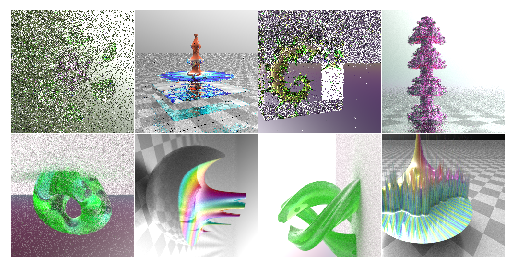

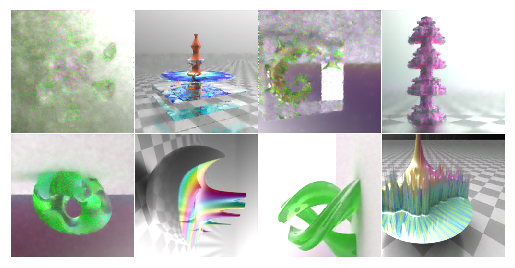

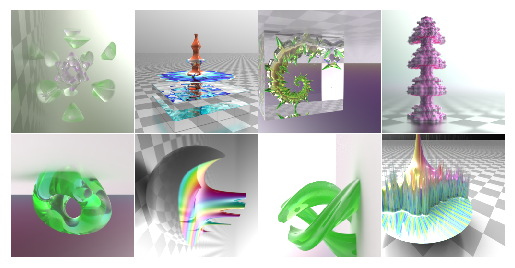

33 g 0.9382388383150101 0.9968306496739388 d 1.392017906904221 1.3919207602739334 lr 0.002 0.002
34 g 0.9567001715302468 0.9917745664715767 d 1.3917542576789859 1.3917666673660278 lr 0.002 0.002
35 g 0.9385857403278351 1.1271231546998024 d 1.3915151566267014 1.3913473039865494 lr 0.002 0.002
36 g 1.0134369313716887 1.014715239405632 d 1.3911997884511953 1.3911796808242798 lr 0.002 0.002
37 g 1.0059110403060914 0.984252817928791 d 1.3909558355808262 1.3909143209457397 lr 0.002 0.002
38 g 1.0008333012461663 0.9786102548241615 d 1.3906969636678694 1.3907680362462997 lr 0.002 0.002
39 g 0.9551114171743393 0.9858038574457169 d 1.390543183684349 1.3903503268957138 lr 0.002 0.002
40 g 1.033179254829884 0.959345854818821 d 1.390493115782738 1.3904323279857635 lr 0.002 0.002
41 g 0.9253657378256323 0.978085346519947 d 1.390208420157433 1.390038251876831 lr 0.002 0.002
42 g 0.9908908769488335 1.0366103947162628 d 1.3900445371866228 1.389795795083046 lr 0.002 0.002
43 g 0.9060223266482353 0.96435

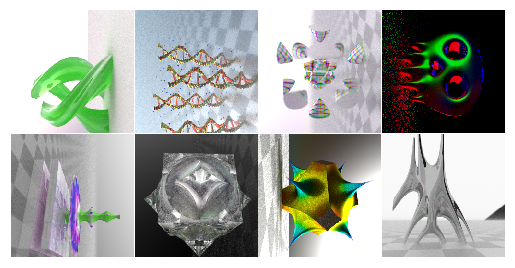

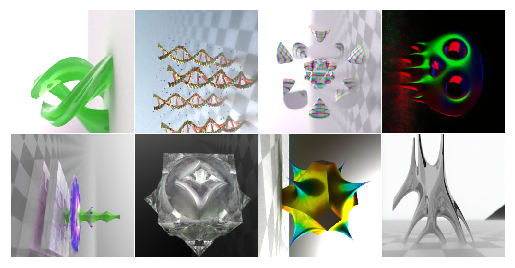

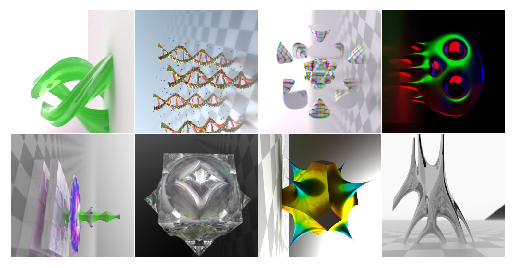

65 g 0.8585272155702117 0.8882982283830643 d 1.3884732067584986 1.388505443930626 lr 0.002 0.002
66 g 0.8832738056778907 0.8822288289666176 d 1.3884083092212678 1.3878549486398697 lr 0.002 0.002
67 g 0.7531415820121766 0.876185305416584 d 1.388060173392296 1.3880130052566528 lr 0.002 0.002
68 g 0.8679727263748646 0.8886756375432014 d 1.3877928704023361 1.387931153178215 lr 0.002 0.002
69 g 0.8158280923962591 0.8881046324968338 d 1.3878556460142137 1.387949362397194 lr 0.002 0.002
70 g 0.9182657584547996 0.8715253695845604 d 1.3877277046442031 1.3876571506261826 lr 0.002 0.002
71 g 0.8544217236340047 0.9114923179149628 d 1.387617391347885 1.3876702636480331 lr 0.002 0.002
72 g 0.9267922788858411 0.9182751402258873 d 1.387738072872162 1.3875688016414642 lr 0.002 0.002
73 g 0.908425386250019 0.8951761499047279 d 1.387644499540329 1.3876880705356598 lr 0.002 0.002
74 g 0.8580346703529358 0.8670359030365944 d 1.3877567529678347 1.3875616937875748 lr 0.002 0.002
75 g 0.9200850382447244 0.873

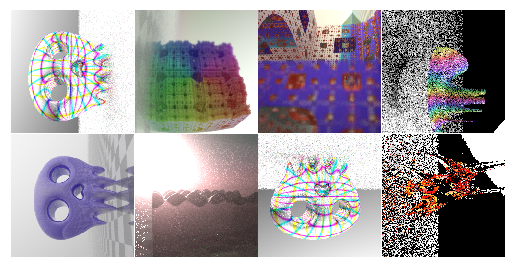

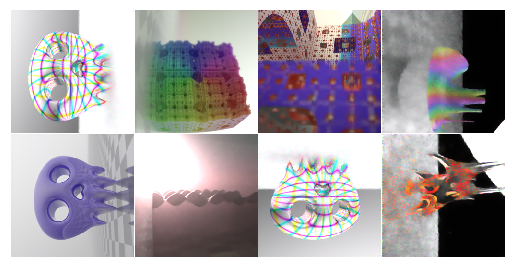

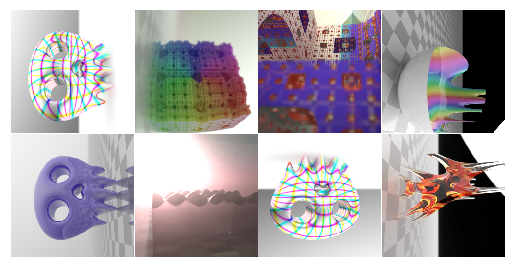

97 g 0.8246757812798022 0.8444783017039299 d 1.3870914727449417 1.387000322341919 lr 0.002 0.002
98 g 0.781568894535303 0.8350159451365471 d 1.3870053321123128 1.3868926763534546 lr 0.002 0.002
99 g 0.891578558832407 0.8652080371975899 d 1.3869929015636444 1.3869014382362366 lr 0.002 0.002
100 g 0.9007822729647158 0.8754060491919518 d 1.386893138289452 1.3868795782327652 lr 0.002 0.002
101 g 0.8222120203077793 0.8685248494148254 d 1.3869152396917346 1.3893354535102844 lr 0.002 0.002
102 g 0.8217861041426658 0.8560117930173874 d 1.3872071117162703 1.3868333101272583 lr 0.002 0.002
103 g 0.8723534479737279 0.850542776286602 d 1.3868814766407018 1.3868050426244736 lr 0.002 0.002
104 g 0.8574348039925099 0.8431099280714989 d 1.3868957191705702 1.3868018984794617 lr 0.002 0.002
105 g 0.7553628899157049 0.8240648433566093 d 1.3866808354854583 1.3867998570203781 lr 0.002 0.002
106 g 0.8020155973732472 0.8578228652477264 d 1.386908215284347 1.3867454379796982 lr 0.002 0.002
107 g 0.81895692571

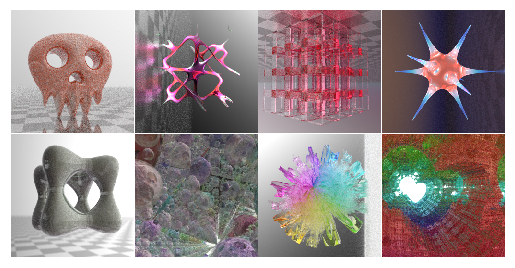

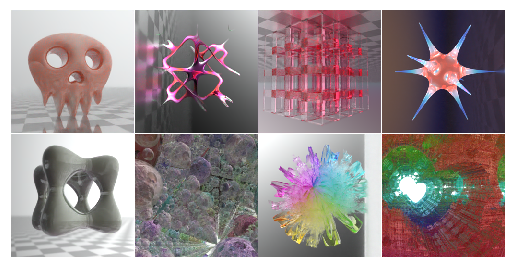

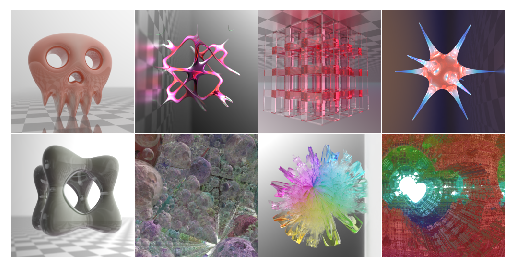

129 g 0.7576878160238266 0.799623116850853 d 1.3864515036344527 1.3867023587226868 lr 0.0006 0.00017999999999999998
130 g 0.7875743903219699 0.7935817316174507 d 1.3864011734724042 1.3867285251617432 lr 0.0006 0.00017999999999999998
131 g 0.7064349517226219 0.7830550074577332 d 1.3855109781026842 1.3867013156414032 lr 0.0006 0.00017999999999999998
132 g 0.769176473468542 0.7913206368684769 d 1.386249855160713 1.3867058902978897 lr 0.0006 0.00017999999999999998
133 g 0.8148642413318156 0.7861046344041824 d 1.386238810420036 1.3867197036743164 lr 0.0006 0.00017999999999999998
134 g 0.8186362728476523 0.7884547337889671 d 1.3864764392375943 1.3866949379444122 lr 0.0006 0.00017999999999999998
135 g 0.7691853985190393 0.7858751192688942 d 1.386268836259842 1.3866928219795227 lr 0.0006 0.00017999999999999998
136 g 0.7770711839199066 0.7877128943800926 d 1.3862299233675002 1.3867402374744415 lr 0.0006 0.00017999999999999998
137 g 0.6936930134892464 0.7956337630748749 d 1.3866527438163754 1.38

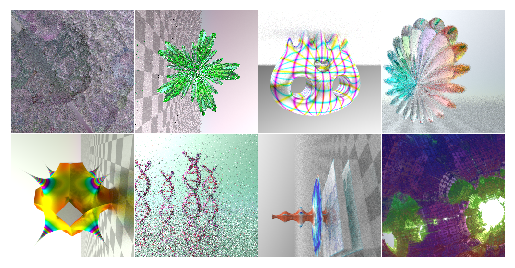

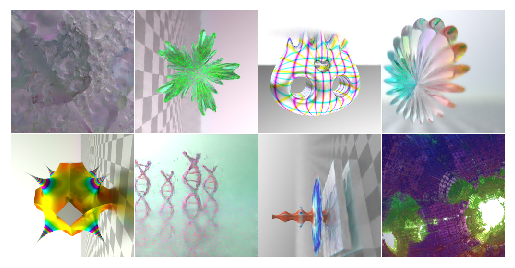

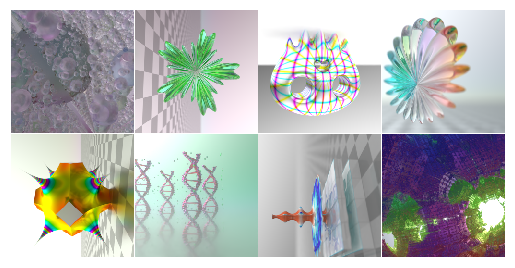

161 g 0.7452906124293803 0.7761597707867622 d 1.3855315178632734 1.3865342885255814 lr 0.0006 0.0001
162 g 0.759722124040127 0.7787793800234795 d 1.3852560490369794 1.3865366131067276 lr 0.0006 0.0001
163 g 0.7903375312685967 0.7707415968179703 d 1.3865592449903485 1.3865162879228592 lr 0.0006 0.0001
164 g 0.7618951454758643 0.7884669452905655 d 1.385531321167946 1.3865682035684586 lr 0.0006 0.0001
165 g 0.7434823766350743 0.7763457372784615 d 1.3866094142198562 1.3865339010953903 lr 0.0006 0.0001
166 g 0.7524072006344794 0.7860968932509422 d 1.3861402988433833 1.386528104543686 lr 0.0006 0.0001
167 g 0.728884867578745 0.7777667194604874 d 1.3860025256872173 1.3864994794130325 lr 0.0006 0.0001
168 g 0.7430987656116484 0.772365041077137 d 1.385218152403832 1.3865579515695572 lr 0.0006 0.0001
169 g 0.757118272781372 0.7749827727675438 d 1.3858327329158786 1.3865863382816315 lr 0.0006 0.0001
170 g 0.7509970001876355 0.7749557644128799 d 1.3863253682851793 1.3866682797670364 lr 0.0006 0.00

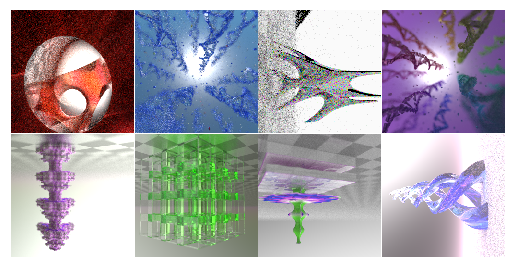

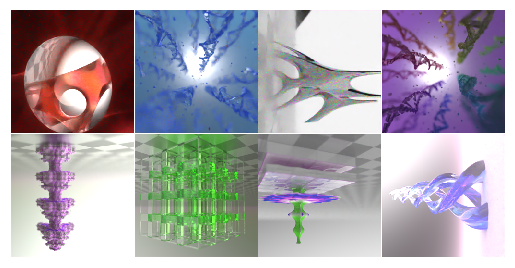

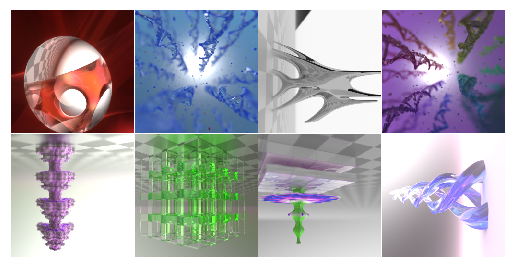

193 g 0.7636656865477561 0.761529877781868 d 1.385454723238945 1.3863630443811417 lr 0.00017999999999999998 0.0001
194 g 0.778828492760658 0.7647125646471977 d 1.3856431782245635 1.386391058564186 lr 0.00017999999999999998 0.0001
195 g 0.7716494277119638 0.762019868940115 d 1.385610315203667 1.386438012123108 lr 0.00017999999999999998 0.0001
196 g 0.748090087622404 0.7611342817544937 d 1.3847462296485902 1.3865077197551727 lr 0.00017999999999999998 0.0001
197 g 0.7113214299082754 0.7624137103557587 d 1.3853659749031062 1.3864719867706299 lr 0.00017999999999999998 0.0001
198 g 0.7725499808788299 0.7630913369357586 d 1.3856580853462217 1.3863975405693054 lr 0.00017999999999999998 0.0001
199 g 0.7400552876293659 0.766229934990406 d 1.3862922370433808 1.3863718807697296 lr 0.00017999999999999998 0.0001
200 g 0.7682043544948101 0.7601422816514969 d 1.3863834291696544 1.386483758687973 lr 0.00017999999999999998 0.0001
201 g 0.7350526817142962 0.7588083706796169 d 1.3853816628456117 1.3864345

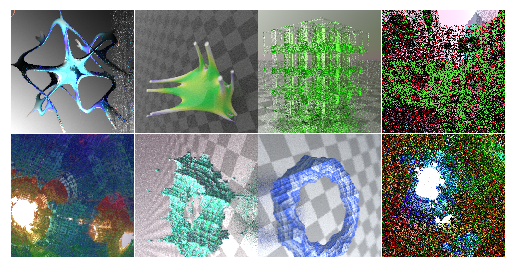

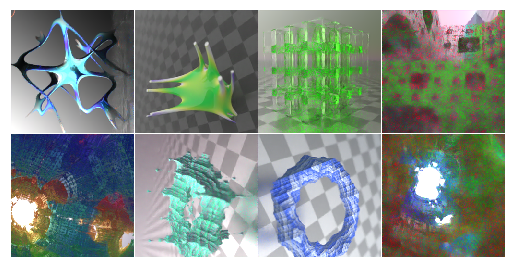

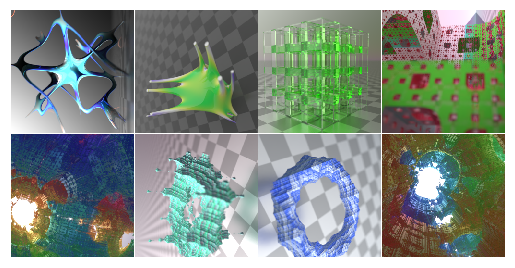

225 g 0.747898392379284 0.7591405063867569 d 1.385365918278694 1.3862776011228561 lr 0.00017999999999999998 0.0001
226 g 0.7748378008604049 0.7629473432898521 d 1.3845816493034366 1.3862833678722382 lr 0.00017999999999999998 0.0001
227 g 0.7980521850287914 0.7594081200659275 d 1.3845476984977725 1.3862575888633728 lr 0.00017999999999999998 0.0001
228 g 0.8003422319889067 0.7627558819949627 d 1.3852947652339935 1.3862673342227936 lr 0.00017999999999999998 0.0001
229 g 0.762635289877653 0.7558061890304089 d 1.3849216878414154 1.3862861543893814 lr 0.00017999999999999998 0.0001
230 g 0.719027765840292 0.7582202702760696 d 1.3856075286865235 1.386194795370102 lr 0.00017999999999999998 0.0001
231 g 0.73316186144948 0.7569171339273453 d 1.3857930034399033 1.3862831145524979 lr 5.399999999999999e-05 0.0001
232 g 0.7284226424992083 0.7522548362612724 d 1.384812220931053 1.3863844871520996 lr 5.399999999999999e-05 0.0001
233 g 0.7651991389691829 0.7535147331655025 d 1.3852124780416486 1.3862234

In [7]:
discriminator_params = torch.cat([x.view(-1) for x in discriminator.parameters()])

batch_size = 24  # how much RAM do I have?
batch_per_epoch = 40
batch_per_epoch_val = 8

num_epoch = 1024

dataset = RawDataset(batch_size*batch_per_epoch)

valloader = []
for x, y in torch.utils.data.DataLoader(dataset, batch_size=batch_size):
    valloader.append((x, y))
    if len(valloader) >= batch_per_epoch_val:
        break

print("Ready")

for epoch in range(num_epoch):

    # training
    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)
    mean_loss_g, mean_loss_d = 0.0, 0.0
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Update Discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(y)
        d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

        fake_images = model(x)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        regl2 = 1.0 * torch.mean((discriminator_params)**2)
        regl2.backward()
        optimizer_d.step()

        # Update Generator
        optimizer.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = lossfun(fake_images, y, fake_outputs)
        g_loss.backward()
        optimizer.step()

        mean_loss_g += g_loss.item() / batch_per_epoch
        mean_loss_d += d_loss.item() / batch_per_epoch
    
    # validation
    mean_loss_gv, mean_loss_dv = 0.0, 0.0
    with torch.no_grad():
        for x, y in valloader:
            x = x.to(device)
            y = y.to(device)
            x = torch.log(1+x)
            y = torch.log(1+y)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            real_outputs = discriminator(y)
            d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

            fake_images = model(x)
            fake_outputs = discriminator(fake_images)
            d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

            d_loss = d_loss_real + d_loss_fake
            g_loss = lossfun(fake_images, y, fake_outputs)

            mean_loss_gv += g_loss.item() / batch_per_epoch_val
            mean_loss_dv += d_loss.item() / batch_per_epoch_val
    
    # scheduling / verbose
    epoch += 1
    scheduler.step(mean_loss_gv)
    scheduler_d.step(mean_loss_dv)
    if scheduler.get_last_lr()[0] <= scheduler.min_lrs[0]:
        break
    print(f"{epoch} g {mean_loss_g} {mean_loss_gv} d {mean_loss_d} {mean_loss_dv} lr {scheduler.get_last_lr()[0]} {scheduler_d.get_last_lr()[0]}")
    torch.save(model, "attunet1_1.pth")
    torch.save(discriminator, "attunet1_1d.pth")
    if epoch % 32 == 0:
        loader = torch.utils.data.DataLoader(dataset, batch_size=8)
        for x, y in loader:
            with torch.no_grad():
                x1 = torch.log(1+x.to(device))
                y1 = torch.exp(model(x1))-1
            plot_imgs(x)
            plot_imgs(y1)
            plot_imgs(y)
            break

print("Done")